In [1]:
import pandas as pd
import numpy as np
import os

data_dir = 'C:/Users/Sakshee/Documents/DATASETS/Boschs Traffic Sign Recognition/images_color'
test_dir = 'C:/Users/Sakshee/Documents/DATASETS/Boschs Traffic Sign Recognition/images_test'
category_names = os.listdir(data_dir)
num_classes = len(category_names)
print(num_classes)

images = []
for category in category_names:
    folder = data_dir + '/' + category
    images.append(len(os.listdir(folder)))

43


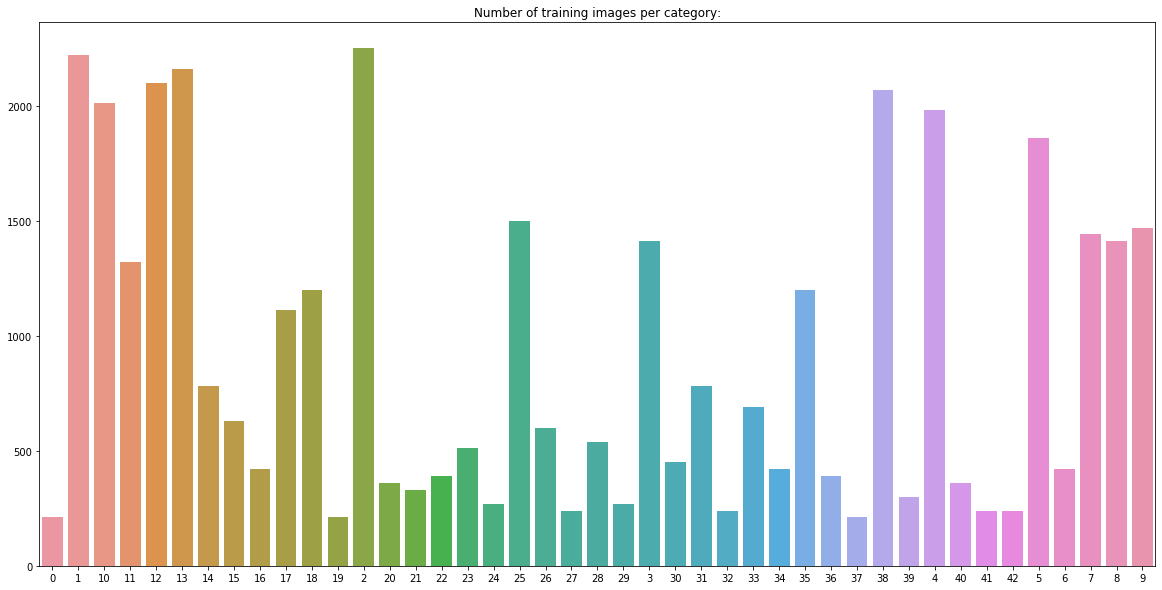

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
sns.barplot(category_names, images).set_title("Number of training images per category:")
plt.show()

In [3]:
from keras.preprocessing.image import img_to_array, load_img
from PIL import Image

data = []
labels = []
img_size = 32
channels = 3

for i in range(num_classes):
    path = os.path.join(data_dir, str(i))
    images = os.listdir(path)
    
    for a in images:
        image = Image.open(path + '/' + a)
        image = image.resize((img_size, img_size))
        image = np.array(image)
        data.append(image)
        labels.append(i)           

data = np.array(data)      
labels = np.array(labels) 

Using TensorFlow backend.


In [4]:
print(data.shape)
print(labels.shape)

(39209, 32, 32, 3)
(39209,)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(31367, 32, 32, 3) (7842, 32, 32, 3) (31367,) (7842,)


In [7]:
import keras
from keras.utils import to_categorical

Y_train=keras.utils.to_categorical(Y_train, num_classes)
Y_val= keras.utils.to_categorical(Y_val, num_classes)

print(Y_train.shape)
print(Y_val.shape)

(31367, 43)
(7842, 43)


In [11]:
from keras.layers.core import Layer
import tensorflow as tf

class SpatialTransformer(Layer):

    def __init__(self, localization_net, output_size, **kwargs):
        self.locnet = localization_net
        self.output_size = output_size
        super(SpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.locnet.build(input_shape)
        self.trainable_weights = self.locnet.trainable_weights

    def compute_output_shape(self, input_shape):
        output_size = self.output_size
        return (None,
                int(output_size[0]),
                int(output_size[1]),
                int(input_shape[-1]))

    def call(self, X, mask=None):
        affine_transformation = self.locnet.call(X)
        output = self._transform(affine_transformation, X, self.output_size)
        return output

    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])

    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = tf.shape(image)[1]
        width = tf.shape(image)[2]
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x = .5*(x + 1.0)*(width_float)
        y = .5*(y + 1.0)*(height_float)

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)

        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output

    def _meshgrid(self, height, width):
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = tf.reshape(x_coordinates, shape=(1, -1))
        y_coordinates = tf.reshape(y_coordinates, shape=(1, -1))
        ones = tf.ones_like(x_coordinates)
        indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
        return indices_grid

    def _transform(self, affine_transformation, input_shape, output_size):
        batch_size = tf.shape(input_shape)[0]
        height = tf.shape(input_shape)[1]
        width = tf.shape(input_shape)[2]
        num_channels = tf.shape(input_shape)[3]

        affine_transformation = tf.reshape(affine_transformation, shape=(batch_size,2,3))

        affine_transformation = tf.reshape(affine_transformation, (-1, 2, 3))
        affine_transformation = tf.cast(affine_transformation, 'float32')

        width = tf.cast(width, dtype='float32')
        height = tf.cast(height, dtype='float32')
        output_height = output_size[0]
        output_width = output_size[1]
        indices_grid = self._meshgrid(output_height, output_width)
        indices_grid = tf.expand_dims(indices_grid, 0)
        indices_grid = tf.reshape(indices_grid, [-1]) # flatten?
        indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
        indices_grid = tf.reshape(indices_grid, tf.stack([batch_size, 3, -1]))

        # transformed_grid = tf.batch_matmul(affine_transformation, indices_grid)
        transformed_grid = tf.matmul(affine_transformation, indices_grid)
        x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
        y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
        x_s_flatten = tf.reshape(x_s, [-1])
        y_s_flatten = tf.reshape(y_s, [-1])

        transformed_image = self._interpolate(input_shape,
                                                x_s_flatten,
                                                y_s_flatten,
                                                output_size)

        transformed_image = tf.reshape(transformed_image, shape=(batch_size,
                                                                output_height,
                                                                output_width,
                                                                num_channels))
        return transformed_image

In [12]:
from keras.layers import Activation, Dense, Dropout, Flatten, Lambda, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.regularizers import l2
from keras.utils import np_utils

def locnet():
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((64, 6), dtype='float32')
    weights = [W, b.flatten()]
    locnet = Sequential()

    locnet.add(Conv2D(16, (7, 7), padding='valid', input_shape=(img_size, img_size, channels)))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(32, (5, 5), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(64, (3, 3), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))

    locnet.add(Flatten())
    locnet.add(Dense(128))
    locnet.add(Activation('elu'))
    locnet.add(Dense(64))
    locnet.add(Activation('elu'))
    locnet.add(Dense(6, weights=weights))

    return locnet

def conv_model(input_shape=(img_size, img_size, channels)):
    model = Sequential()
    model.add(Lambda(
        lambda x: x/127.5 - 1.,
        input_shape=(img_size, img_size, channels),
        output_shape=(img_size, img_size, channels)))
    model.add(BatchNormalization())
    model.add(Conv2D(10, (1, 1), padding='same', kernel_regularizer=l2(0.05)))
    model.add(LeakyReLU(alpha=0.5))
    model.add(BatchNormalization())
    model.add(Conv2D(3, (1, 1), padding='same', kernel_regularizer=l2(0.05)))
    model.add(LeakyReLU(alpha=0.5))
    model.add(BatchNormalization())
    model.add(SpatialTransformer(localization_net=locnet(), output_size=(img_size, img_size)))
    model.add(Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(96, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(192, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(num_classes, activation="softmax"))
    return model

In [13]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

batch_size = 128
epochs = 150

model = conv_model()

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.fit(X_train, Y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, Y_val),
                shuffle=True,)

ValueError: Error when checking target: expected dense_8 to have shape (1,) but got array with shape (43,)

In [ ]:
import cv2

test_data = []
test_labels = []

for i in range(num_classes):
    path = os.path.join(test_dir, str(i))
    images = os.listdir(path)
    
    for a in images:
        image = cv2.imread(path + '/' + a)
        image = cv2.resize(image, (img_size, img_size))
        image = np.array(image)
        test_data.append(image)
        test_labels.append(i)           

test_data = np.array(test_data)      
test_labels = np.array(test_labels) 

In [ ]:
test_labels = keras.utils.to_categorical(test_labels, num_classes)
print(test_labels.shape)